### Sistema de Recomendación

In [1]:
# Importar librerías:
import numpy as np
import pandas as pd
import seaborn as sns
from math import sqrt
import geopandas as gpd
from apyori import apriori
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
from dateutil.parser import parse 
plt.rcParams.update({'figure.figsize': (8, 6), 'figure.dpi': 120})
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Cargar dataset
data = pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
data. head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Elimino filas sin países
data = data.loc[(data['Country'] != "Unspecified")] 
# Calculo las ventas totatles
data['venta_total'] = data.Quantity * data.UnitPrice
# Convertir la columna "fecha_hora" a formato de fecha y hora
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# Separar la fecha y los minutos/segundos en columnas separadas
data['Date'] = data['InvoiceDate'].dt.date
data['minutos_segundos'] = data['InvoiceDate'].dt.time
# Elimino la columna (que no usaré) InvoiceDate:
data = data.drop(['InvoiceDate'], axis=1)

In [4]:
data_2 = data.groupby("Country", group_keys=False, as_index=False).sum('venta_total')
data_2 = data_2.sort_values('venta_total',ascending=False)
data_2 = data_2[:21]
data_2.head(3)

,Country,Quantity,UnitPrice,CustomerID,venta_total
36,United Kingdom,4263829,2.245715e+06,5.626433e+09,8.187806e+06
24,Netherlands,200128,6.492550e+03,3.419054e+07,2.846615e+05
10,EIRE,142637,4.844719e+04,1.103917e+08,2.632768e+05


## Gráficos

<function matplotlib.pyplot.show(close=None, block=None)>

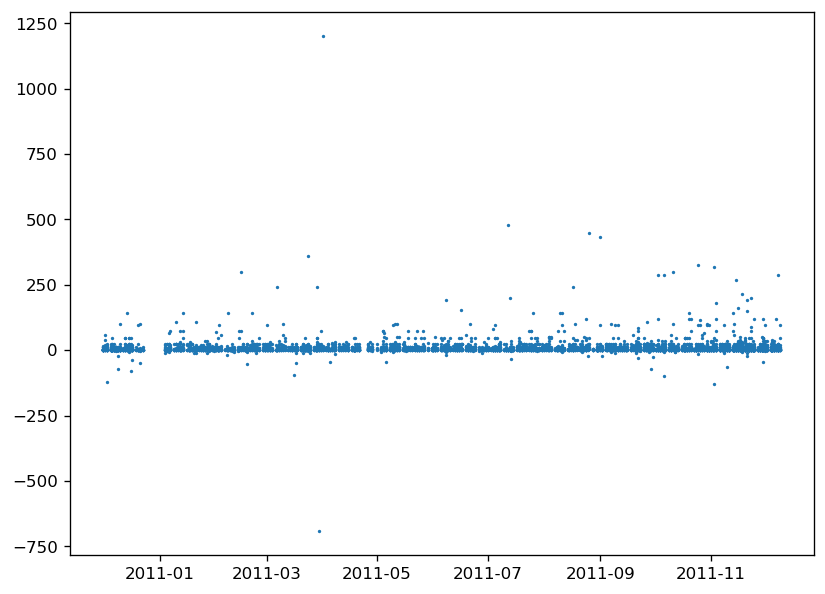

In [5]:
dataShort = data[::100]
plt.scatter(dataShort["Date"], dataShort["Quantity"] , s=1)
plt.show

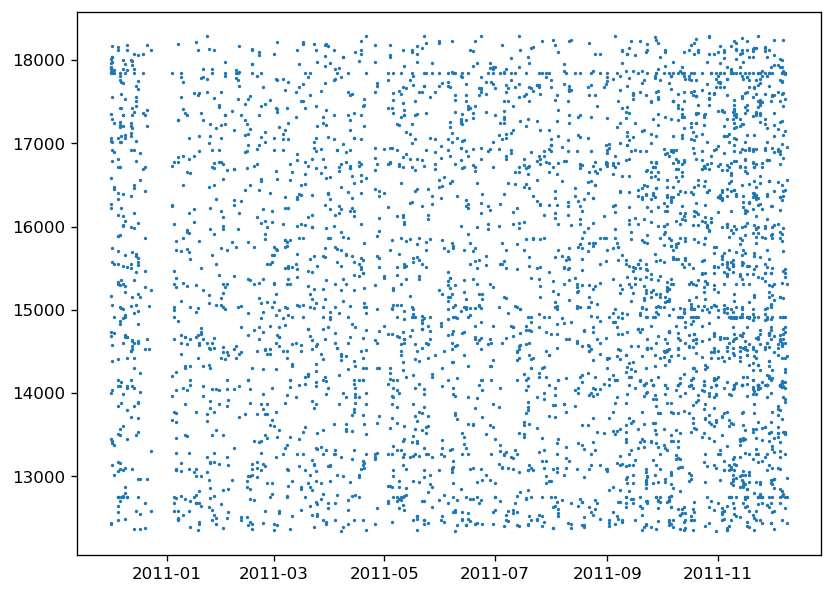

In [6]:
plt.scatter(dataShort["Date"], dataShort["CustomerID"], s=1)

In [7]:
data_2["logVentaTotal"] = np.log10(data_2["venta_total"])
data_2

,Country,Quantity,UnitPrice,CustomerID,venta_total,logVentaTotal
36,United Kingdom,4263829,2.245715e+06,5.626433e+09,8.187806e+06,6.913168
24,Netherlands,200128,6.492550e+03,3.419054e+07,2.846615e+05,5.454329
10,EIRE,142637,4.844719e+04,1.103917e+08,2.632768e+05,5.420413
14,Germany,117448,3.766600e+04,1.200751e+08,2.216982e+05,5.345762
13,France,110480,4.303199e+04,1.076489e+08,1.974039e+05,5.295356
0,Australia,83653,4.054750e+03,1.569300e+07,1.370773e+05,5.136965
33,Switzerland,30325,6.813690e+03,2.377592e+07,5.638535e+04,4.751166
31,Spain,26824,1.263345e+04,3.268929e+07,5.477458e+04,4.738579
3,Belgium,23152,7.540130e+03,2.571829e+07,4.091096e+04,4.611840
32,Sweden,35637,1.806830e+03,6.790083e+06,3.659591e+04,4.563433


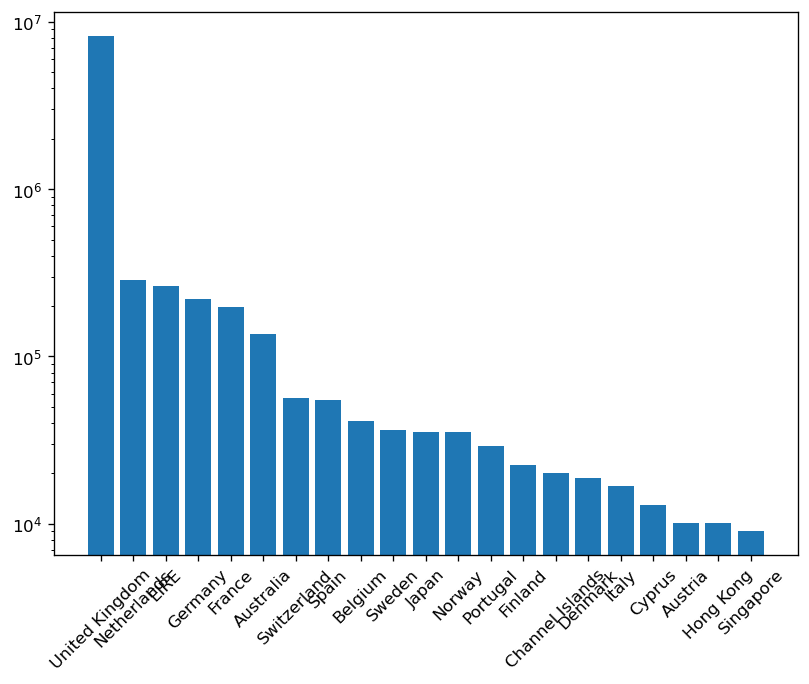

In [8]:
# Crear la gráfica de barras
plt.bar(data_2.Country, data_2['venta_total'])
plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

<AxesSubplot:>

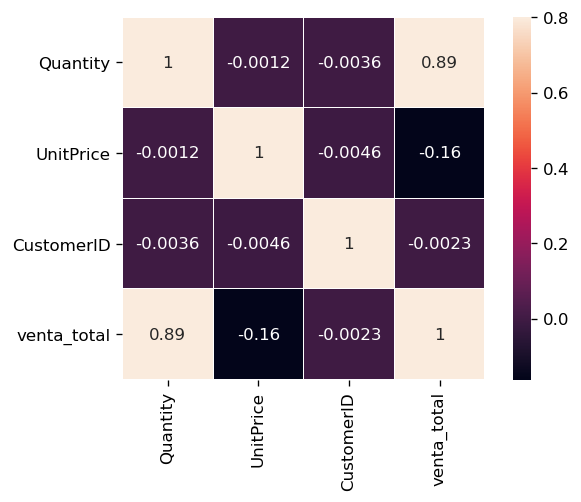

In [9]:
# Mapa de correlaciones
corr = data.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, vmax=.8, linewidths=0.01, square=True,annot=True)

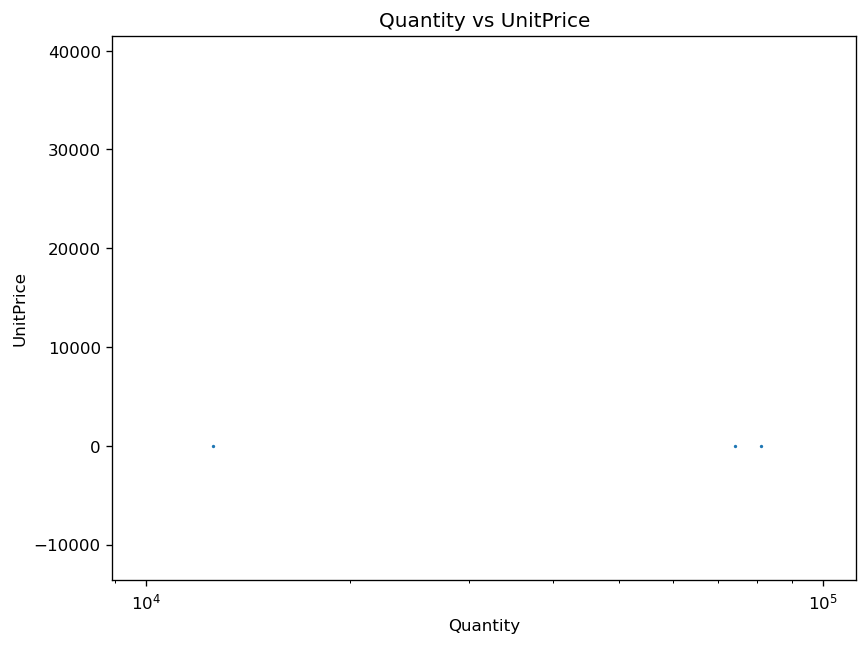

In [10]:
# Gráfica de dispersión (scatter) de Quantity vs UnitPrice 
plt.scatter(data['Quantity'], data['UnitPrice'], s=1)
plt.title("Quantity vs UnitPrice")
plt.xlabel("Quantity")
plt.ylabel("UnitPrice")
plt.xscale('log')
#plt.yscale('log')
plt.show()

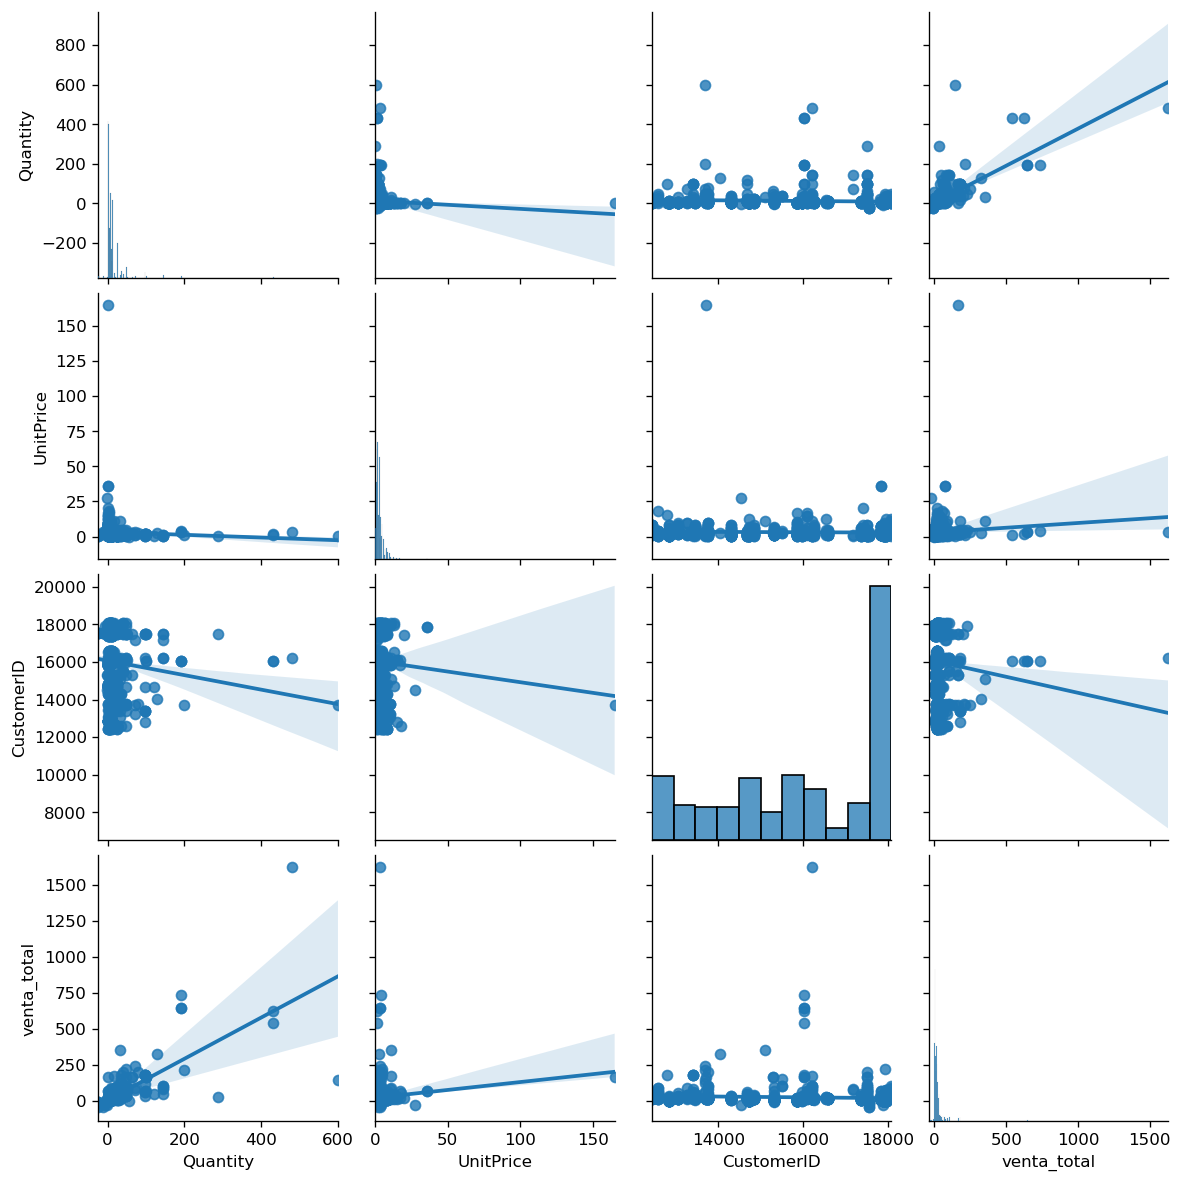

In [11]:
# Seaborn o PairGrid:
sns.pairplot(data[:1000], kind="reg")
plt.show()

In [12]:
data_vtas_totales_paises = data.groupby("Country", group_keys=False, as_index=False).sum('venta_total')
data_vtas_totales_paises = data_vtas_totales_paises.sort_values('venta_total',ascending=False)
data_vtas_totales_paises["logVentaTotal"] = np.log10(data_vtas_totales_paises["venta_total"])
data_vtas_totales_paises

,Country,Quantity,UnitPrice,CustomerID,venta_total,logVentaTotal
36,United Kingdom,4263829,2.245715e+06,5.626433e+09,8.187806e+06,6.913168
24,Netherlands,200128,6.492550e+03,3.419054e+07,2.846615e+05,5.454329
10,EIRE,142637,4.844719e+04,1.103917e+08,2.632768e+05,5.420413
14,Germany,117448,3.766600e+04,1.200751e+08,2.216982e+05,5.345762
13,France,110480,4.303199e+04,1.076489e+08,1.974039e+05,5.295356
0,Australia,83653,4.054750e+03,1.569300e+07,1.370773e+05,5.136965
33,Switzerland,30325,6.813690e+03,2.377592e+07,5.638535e+04,4.751166
31,Spain,26824,1.263345e+04,3.268929e+07,5.477458e+04,4.738579
3,Belgium,23152,7.540130e+03,2.571829e+07,4.091096e+04,4.611840
32,Sweden,35637,1.806830e+03,6.790083e+06,3.659591e+04,4.563433


In [13]:
titles=''.join(str(data.Description)).lower()
titles

"0          white hanging heart t-light holder\n1                         white metal lantern\n2              cream cupid hearts coat hanger\n3         knitted union flag hot water bottle\n4              red woolly hottie white heart.\n                         ...                 \n541904            pack of 20 spaceboy napkins\n541905           children's apron dolly girl \n541906          childrens cutlery dolly girl \n541907        childrens cutlery circus parade\n541908          baking set 9 piece retrospot \nname: description, length: 541463, dtype: object"

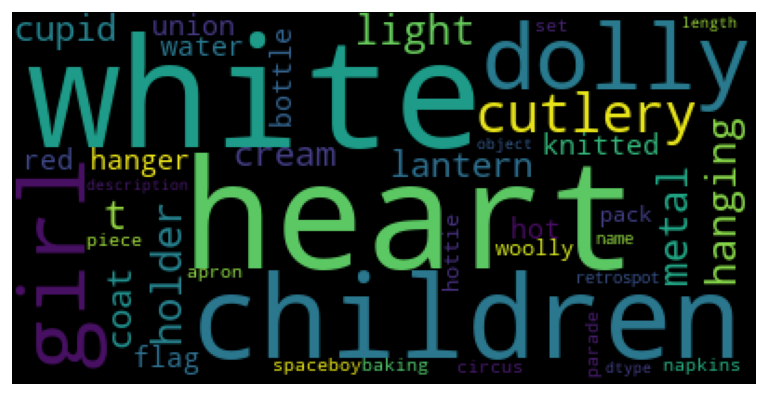

In [14]:
plt.figure(figsize=(8,6))
wordcloud = WordCloud(collocations=True, max_words=500 ).generate(titles)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

2. Construir un mapa que muestre número de compras totales por país y otro con número de compras relativas (per capita) por país.

In [15]:
# Lee los datos de los límites de los países
paises_geo_pandas = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Listado completo: pd.set_option('display.max_rows', 200)
paises_geo_pandas.name.sort_values

<bound method Series.sort_values of 0                          Fiji
1                      Tanzania
2                     W. Sahara
3                        Canada
4      United States of America
                 ...           
172                      Serbia
173                  Montenegro
174                      Kosovo
175         Trinidad and Tobago
176                    S. Sudan
Name: name, Length: 177, dtype: object>

<AxesSubplot:>

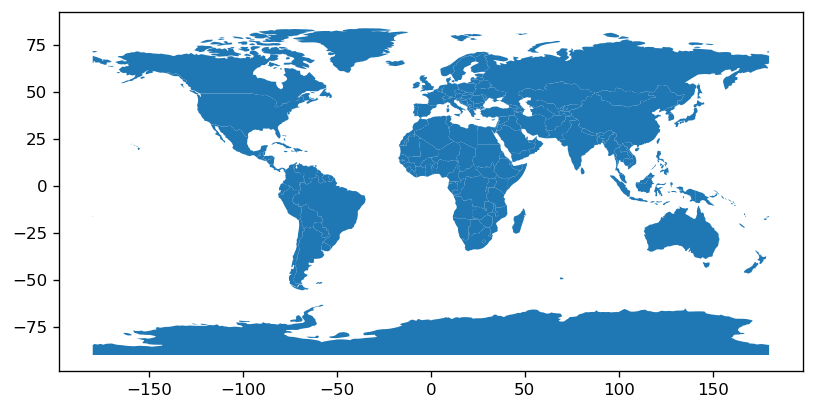

In [16]:
# Verificar si coincide los nombre de países del data frame con los del geopandas
#paises_geo_pandas.loc[paises_geo_pandas["name"]=="Iceland"]
# Crea una figura y un eje
fig, ax = plt.subplots(figsize=(8, 6))
# Dibuja los países en el mapa
paises_geo_pandas.plot(ax=ax)
# Muestra el mapa
#plt.show()   

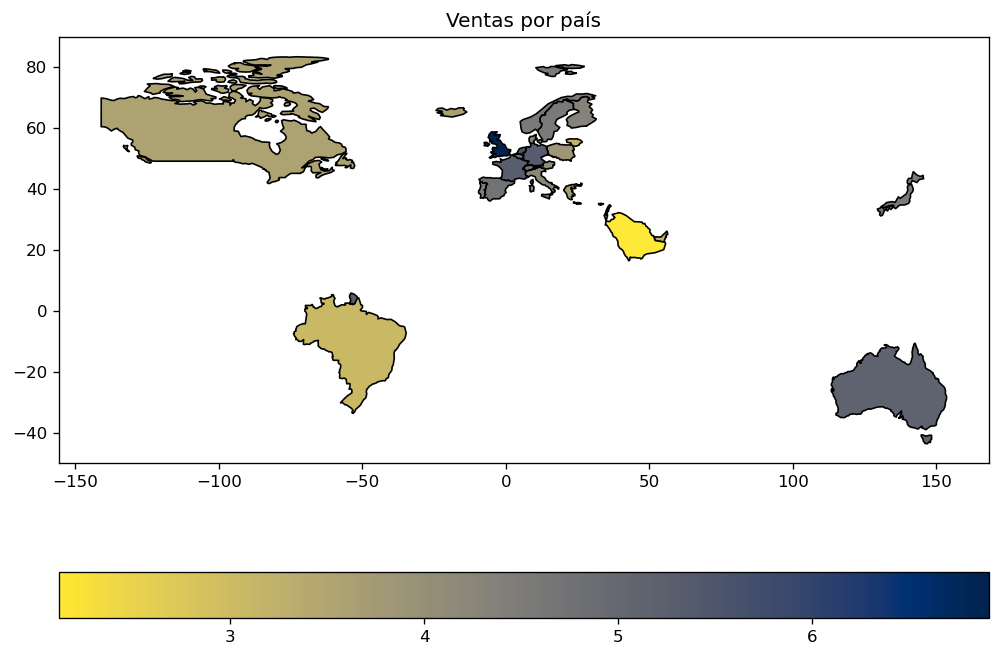

In [17]:
# Unir los datos de los países con los datos de ventas por país
data_merge = paises_geo_pandas.merge(data_vtas_totales_paises, left_on='name', right_on='Country')
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 8))
# Dibujar los países en el mapa y colorearlos según las ventas
data_merge.plot(ax=ax, column='logVentaTotal', cmap='cividis_r', linewidth=0.99, edgecolor='black', legend=True, legend_kwds={'orientation': "horizontal"})
# Añadir un título al mapa
ax.set_title('Ventas por país')    
#plt.yscale('log')
plt.show()

3. Analizar los horarios y calendarios de compra, mediante histogramas y estacionalidad.

In [18]:
# horas = pd.date_range(start=data['minutos_segundos'].min(),end=data['minutos_segundos'].max())
# dfHoras = pd.DataFrame(['minutos_segundos: Horas'])
# Horario de ventas totales: horario_vta_totales = data.groupby("minutos_segundos", group_keys=False, as_index=False).sum('venta_total')
# horario_vta_totales["logVentaTotal"] = np.log10(horario_vta_totales["venta_total"])
# Crear la gráfica de barras: plt.bar(horario_vta_totales.minutos_segundos, horario_vta_totales['venta_total'])
# plt.xticks(rotation=45)
# plt.show()

In [19]:
# Calendario de ventas:
calendario_cant_vta = data.groupby(['Date'], group_keys=False, as_index=False).sum('Quantity')
calendario_cant_vta[calendario_cant_vta['Quantity'] < 0]

,Date,Quantity,UnitPrice,CustomerID,venta_total
152,2011-06-14,-13752,6435.36,16007436.0,40211.93


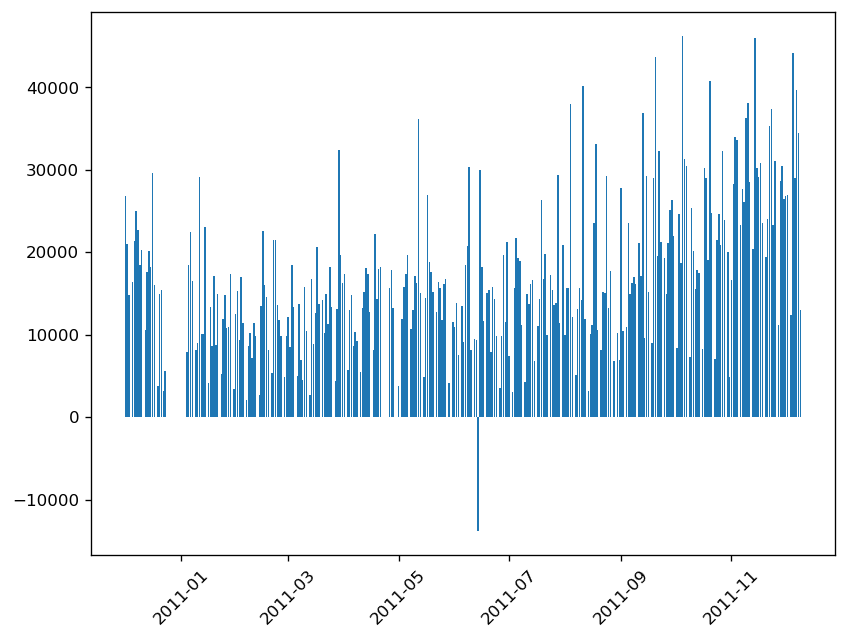

In [20]:
# Crear la gráfica de barras
plt.bar(calendario_cant_vta.Date, calendario_cant_vta['Quantity'])
#plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

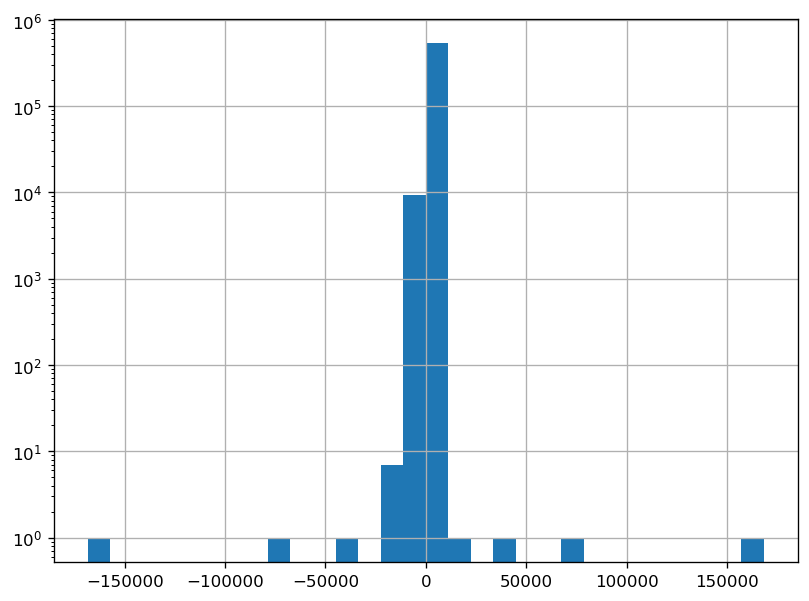

In [21]:
# Historama: Buscando bins más significativos (30 días = 1 mes)
data.venta_total.hist(bins=30)
plt.yscale('log')

4. Crear la **Customer-Item Matrix** mediante el método df.pivot_table

In [22]:
Customer_Item = pd.pivot_table(data, values='Quantity', index=['CustomerID'], columns=['StockCode'], aggfunc=np.sum)
Customer_Item.fillna(value=0, inplace=True)
Customer_Item.head(3)

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214Y,90214Z,BANK CHARGES,C2,CRUK,D,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12348.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0


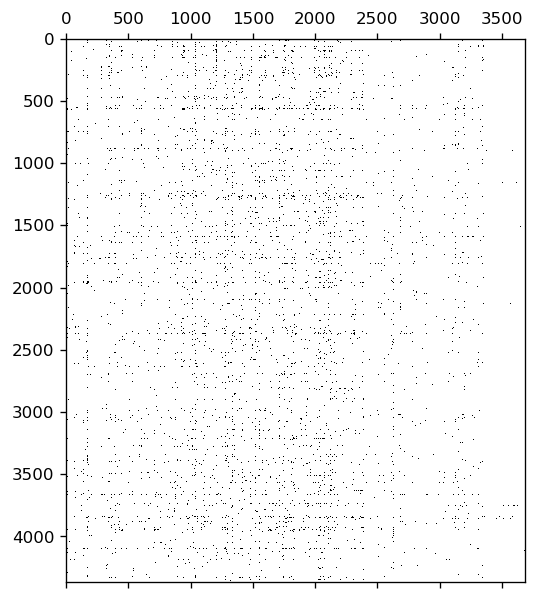

In [23]:
# Matriz para verificar queno todos los valores son NaN
plt.spy(Customer_Item)
plt.show()

5. Crear la **User to User Similarity Matrix** mediante la **distancia del coseno** con la librería sklearn

In [24]:
userUser = pd.DataFrame(cosine_similarity(Customer_Item))
userUser.head(2)

,0,1,2,3,4,5,6,7,8,9,...,4358,4359,4360,4361,4362,4363,4364,4365,4366,4367
0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000
1,0.0,1.0,0.148879,0.02075,0.014435,0.034833,0.0,0.023478,0.506252,0.186107,...,0.0,0.0,0.40706,-0.001245,0.015133,0.037236,0.0,0.011921,0.07451,0.108942


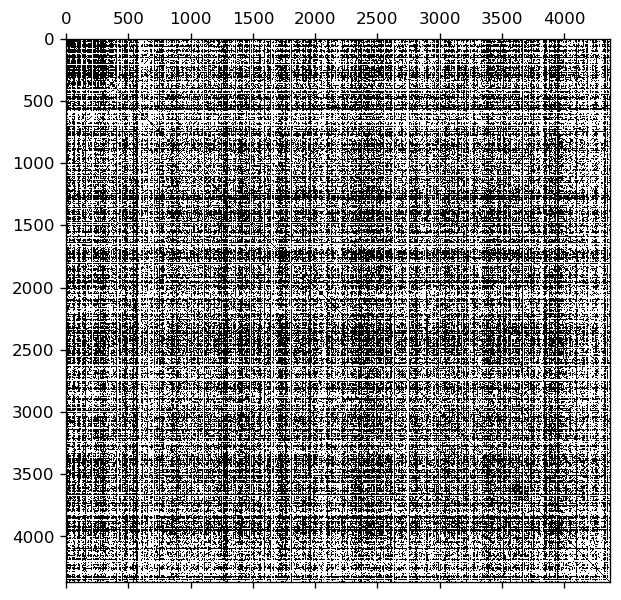

In [25]:
# Calculando la cantidad de usuarios. Matriz de user vs user:
userUser.shape
plt.spy(userUser)
plt.show()

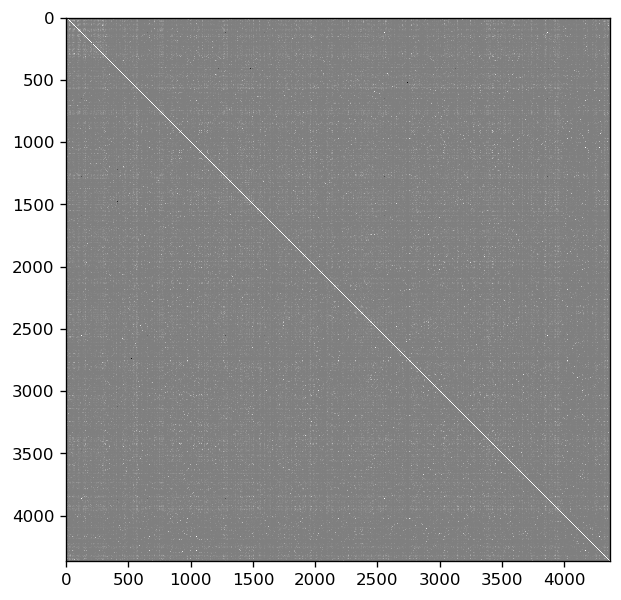

In [26]:
# Graficar matriz densa
plt.imshow(userUser, cmap='gray', interpolation='nearest')
plt.show()

6. Obtener las 10 recomendaciones de tipo **filtrado colaborativo por usuario**.

In [27]:
userUser.columns = Customer_Item.index
userUser.index = Customer_Item.index
userUser.head(2)

CustomerID,12346.0,12347.0,12348.0,12349.0,12350.0,12352.0,12353.0,12354.0,12355.0,12356.0,...,18273.0,18274.0,18276.0,18277.0,18278.0,18280.0,18281.0,18282.0,18283.0,18287.0
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000
12347.0,0.0,1.0,0.148879,0.02075,0.014435,0.034833,0.0,0.023478,0.506252,0.186107,...,0.0,0.0,0.40706,-0.001245,0.015133,0.037236,0.0,0.011921,0.07451,0.108942


In [28]:
userUser.iloc[1]

CustomerID
12346.0    0.000000
12347.0    1.000000
12348.0    0.148879
12349.0    0.020750
12350.0    0.014435
             ...   
18280.0    0.037236
18281.0    0.000000
18282.0    0.011921
18283.0    0.074510
18287.0    0.108942
Name: 12347.0, Length: 4368, dtype: float64

In [29]:
filtrado = userUser.iloc[1]
ranking = filtrado.sort_values(ascending = True)
ranking

CustomerID
14205.0   -0.072934
16742.0   -0.064460
17820.0   -0.062680
16428.0   -0.061159
14483.0   -0.004053
             ...   
12355.0    0.506252
14257.0    0.532188
12674.0    0.540213
14326.0    0.552321
12347.0    1.000000
Name: 12347.0, Length: 4368, dtype: float64

In [30]:
similares = ranking[(ranking > 0) & (ranking < 1)]
similares

CustomerID
13868.0    0.000025
18109.0    0.000046
14530.0    0.000067
13435.0    0.000115
15602.0    0.000123
             ...   
12355.0    0.506252
14257.0    0.532188
12674.0    0.540213
14326.0    0.552321
12347.0    1.000000
Name: 12347.0, Length: 3014, dtype: float64

In [31]:
Customer_Item.loc[list(similares.index)]

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214Y,90214Z,BANK CHARGES,C2,CRUK,D,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
13868.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18109.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14530.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13435.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15602.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12355.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14257.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12674.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


In [32]:
all = Customer_Item.loc[list(similares.index)].sum()
print(all.sort_values(ascending = False).head(10))

StockCode
22197     43581.0
84077     39199.0
85099B    37004.0
21212     32359.0
84879     31926.0
85123A    27305.0
23084     27094.0
22492     25880.0
21977     23940.0
22616     21838.0
dtype: float64


7. Obtener las 10 recomendaciones de tipo **filtrado colaborativo por producto** creando previamente la **Item to Item Similarity Matrix**.

In [33]:
ItemUser = pd.pivot_table(data, values='Quantity', index=['CustomerID'], columns=['Description'], aggfunc=np.sum)

In [ ]:
# Buscar el cliente de posición: 12346.0
ItemUser.CustomerID.index['12346.0']   
# ItemUser.loc['12346.0']  

In [35]:
ItemUser.fillna(value=0, inplace=True)
ItemUser.head(2)

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
Item_Item = pd.DataFrame(cosine_similarity(ItemUser))
Item_Item.head(2)

,0,1,2,3,4,5,6,7,8,9,...,4358,4359,4360,4361,4362,4363,4364,4365,4366,4367
0,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,0.0,1.0,0.148879,0.02075,0.014435,0.034833,0.0,0.022843,0.506252,0.186107,...,0.0,0.0,0.40706,-0.001245,0.015133,0.037236,0.0,0.011921,0.075245,0.108942


In [ ]:
filtrado_item_item = Item_Item.iloc[12347.0]

In [ ]:
ranking_item_item = filtrado_item_item.sort_values(ascending = False)
ranking_item_item

In [ ]:
similares_item_item = ranking_item_item[(ranking_item_item > 0) & (ranking_item_item < 1)]
print(similares_item_item.sort_values(ascending = False).head(10))

8. Obtener las 10 recomendaciones de tipo **basado en contenido** utilizando métricas de texto (Levenshtein o vectorización TF-IDF)

In [55]:
# Extraemos las palabras  
contador = CountVectorizer() 
vectorizador = TfidfVectorizer()  
vectorizador

TfidfVectorizer()

In [56]:
# Crear una matriz dispersa
cantidades = contador.fit_transform(ItemUser.columns)
valores = vectorizador.fit_transform(ItemUser.columns)
# print ("Vector de cantidades", cantidades)
# print ("Vector de valores", valores)

In [57]:
# Generate matrix of word vectors
tfidf_matrix = vectorizador.fit_transform(ItemUser.columns)
# Print the shape of tfidf_matrix
print(tfidf_matrix.shape)

(3896, 2039)


In [58]:
tokens = vectorizador.get_feature_names()
print(tokens)

['10', '11', '12', '120cm', '125g', '15', '15c', '15cm', '16', '16x16cm', '17080', '18pc', '20', '200', '20light', '21', '23', '24', '250g', '25w', '25x24x12cm', '30', '30cm', '30cmx30cm', '34x20cm', '35', '36', '3d', '40', '40cm', '40x40cm', '42', '45cm', '45x30cm', '45x45cm', '50', '500g', '50cm', '5g', '60', '60cm', '60x40cm', '65cmx65cm', '6pc', '70', '72', '75', '78', '8m', 'a4', 'a5', 'a6', 'a7', 'abc', 'abstract', 'acapulco', 'account', 'acrylic', 'address', 'ade', 'adult', 'advent', 'afghan', 'aged', 'ahoy', 'aid', 'air', 'airline', 'airmail', 'alarm', 'album', 'all', 'allium', 'alphabet', 'alpine', 'aluminium', 'am', 'amber', 'amelie', 'amethyst', 'and', 'anemone', 'angel', 'angels', 'animal', 'animals', 'ant', 'antique', 'antoienett', 'antoinette', 'aperitif', 'apothecary', 'apple', 'apples', 'apron', 'aqua', 'area', 'army', 'art', 'articulated', 'artificial', 'artiifcial', 'ashtray', 'ass', 'assorted', 'asst', 'asstd', 'azure', 'babushka', 'baby', 'back', 'backpack', 'bad', 

In [59]:
# 3.- Le paso una recomendacion
recomendacion = "PACK OF 20 SPACEBOY NAPKINS"
recomendacion

'PACK OF 20 SPACEBOY NAPKINS'

In [60]:
preguntaVector = vectorizador.transform([recomendacion])
preguntaVector

<1x2039 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [61]:
# print(preguntaVector)
def vector2df(vector, tokens):
    dfPregunta = pd.DataFrame()

    # Obtener la frecuencia de cada token en la pregunta
    frecuencias = np.array(vector.sum(axis=0))[0]
    # Imprimir los tokens y sus frecuencias
    # La función zip(tokens, frecuencias) combina las listas tokens y frecuencias para formar una secuencia de tuplas
    for token, frecuencia in zip(tokens, frecuencias):
        if frecuencia > 0:
            # print(token, frecuencia)
            dfPregunta.loc[token, "frecuencia"] = frecuencia
    dfPregunta = dfPregunta.sort_values("frecuencia", ascending=False)
    return dfPregunta
vector2df(preguntaVector, tokens)

,frecuencia
napkins,0.541526
20,0.517078
spaceboy,0.443809
pack,0.391274
of,0.298861


In [62]:
coseno_similares = cosine_similarity(preguntaVector, tfidf_matrix)
coseno_similares
# Obtener el índice de los 10 mayores números de una lista de los productos que más se parecen 
mejores_resultados = np.argsort(coseno_similares)[0]
mejores_resultados = np.flip(mejores_resultados)[:100] # inverse rearrange on numpy
mejores_resultados

array([2263, 2260, 2261, 2262, 3009, 2228, 3120, 3119, 2955, 2252, 2227,
       2278, 3008, 3032, 3037, 3670, 3335, 3142, 3324,   38, 3329, 3330,
       3325,  710, 2259, 2245, 2248, 2250, 1986, 1987, 2256, 2242, 2251,
       3326, 1988, 2247, 2238, 2266, 3327,  706, 2241, 2053, 2254, 2271,
       1774, 2272, 1956,  272, 2258, 2244, 2257, 2273, 2267, 2237, 1989,
       2243,  697, 2269, 2268, 1799, 2279, 2249, 3331, 2239, 3470,    9,
       3332,   30, 2274, 2255, 2277,  692, 2253, 2280, 2246, 2275, 3328,
       2264, 2240, 2276,  699, 2265,  714, 2945, 2583, 2270, 1984,   12,
        231, 2281, 2063, 2964, 3334, 1980, 1985,  275,   48, 2235, 3333,
       2231], dtype=int64)

In [65]:
for i in mejores_resultados:
    print(i)
    print(coseno_similares[0][i])
    # Obtener el vector de características del documento de interés
    vector_documento = tfidf_matrix[i]
    print(vector2df(vector_documento, tokens)[:5])
print(recomendacion)
print("\n")

for i in mejores_resultados:
    print('"' + ItemUser.columns["Descriptions"][i] + '"')
    #print("\t - " + enlaces[i] + "\n")    
print(recomendacion)
#respuesta = textos[coseno_similares.argmax()]
print("\n\t" + recomendacion)
# df["textos"][coseno_similares.argmax()]

2263
1.0
          frecuencia
napkins     0.541526
20          0.517078
spaceboy    0.443809
pack        0.391274
of          0.298861
2260
0.7550449693310299
         frecuencia
napkins    0.509165
20         0.486178
pantry     0.427743
pack       0.367892
design     0.327280
2261
0.7413047839020267
         frecuencia
napkins    0.499899
apples     0.482351
20         0.477331
pack       0.361197
red        0.288126
2262
0.736652169163275
         frecuencia
napkins    0.496762
20         0.474335
skull      0.450005
pack       0.358930
paper      0.348909
3009
0.6737035428401983
           frecuencia
napkins      0.561327
20           0.535985
christmas    0.348397
vintage      0.317679
of           0.309789
2228
0.6381800414737419
         frecuencia
napkins    0.484214
20         0.462354
english    0.453532
pack       0.349864
paper      0.340096
3120
0.5596250147989842
            frecuencia
napkins       0.540564
20            0.516160
strawberry    0.472880
paper         0.37

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

9. Realizar un **market basket analysis** para detectar **bundles** (packs) de productos. Algoritmos de clusterización como K-means podrían detectar los bundles más frecuentes.

In [ ]:
#mlens= pd.read_csv('OnlineRetail.csv', encoding='ISO-8859-1')
mlens = data.rename(columns={'CustomerID': "user_id", "StockCode" : "item_id", "UnitPrice" : "rating", "Date" : "timestamp"}, inplace=True)

In [ ]:
mlens = data.drop(["InvoiceNo", "Description", "Quantity", "Country"], axis=1)
mlens

In [ ]:
# primero vamos a mapear los ids de usuario y de pelicula a un nuevo id que sea un indice
user2ix = {user:ix for ix,user in enumerate(mlens.user_id.unique())}
ix2user = {user2ix[k]:k for k in user2ix.keys()}

item2ix = {item:ix for ix,item in enumerate(mlens.item_id.unique())}
ix2item = {item2ix[k]:k for k in item2ix.keys()}

In [ ]:
mlens_con_ix = mlens.copy()

In [ ]:
# Eliminar los NaN: 
mlens_2 = mlens.notna()

In [ ]:
mlens_con_ix["user_id"] = mlens_2.user_id.apply(lambda x: user2ix[x])
mlens_con_ix["item_id"] = mlens_2.item_id.apply(lambda x: item2ix[x])

In [ ]:
# hacemos un pivot sobre el dataframe para tener la matriz usuario-item, esta no es la forma mas eficiente: estamos usando un dataframe
# pero pdist y cdist no toman una sparse matrix como input, para este problema no requerimos una sparse matrix necesariamente:
mlens_pivotada = mlens.pivot("item_id","user_id")["rating"]
# ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
# calculando la similitud
similitudes = squareform(pdist(mlens_pivotada,metric=fast_cosine))

In [ ]:
# Función que devuelva el rating original si este existe, caso contrario, devuelve el predicho:
def predecir(user,item,similitudes,original,user2ix,item2ix):
    ix_user = user2ix[user]
    ix_item = item2ix[item]
    score = original.iloc[ix_item,ix_user]
    if np.isnan(score):
        item_similitudes = similitudes[:,ix_item]
        user_scores = original.iloc[:,ix_user].values
        k = np.nansum(item_similitudes[~np.isnan(user_scores)]) ## este es el denominador de la funcion
        
        if k == 0: 
            ## si nadie le puso puntaje al item o las similitudes son todas 0 devuelvo un score arbitrario
            return 2.5
        
        score = np.nansum(user_scores*item_similitudes)
        score = score/k
    return scoreuser = 554

In [ ]:
item = 651
predecir(user,item,similitudes,mlens_pivotada,user2ix,item2ix)